In [ ]:
import sys
!{sys.executable} -m pip install --upgrade pip -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.1 MB/s eta 0:00:00


🚀 Baseline 1 - Vanilla Diffusion Model Started
Loading Adult Income Dataset from local path...
✅ Loaded dataset shape: (48843, 15)
✅ Cleaned dataset shape: (48843, 15)
✅ Normalized shape: (48843, 15)
✅ Train: 39074, Test: 9769
✅ Scheduler initialized
✅ Model initialized (305,679 params)
Epoch 10/50: Loss=0.0778
Epoch 20/50: Loss=0.0688
Epoch 30/50: Loss=0.0671
Epoch 40/50: Loss=0.0662
Epoch 50/50: Loss=0.0653
✅ Training complete


Generating:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Generated synthetic samples: (1000, 15)


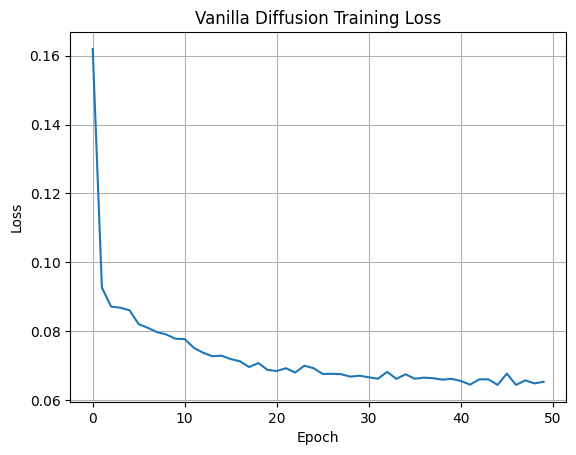

In [2]:
# =========================================================
# 🧠 BASELINE 1: Vanilla Diffusion Model (No Fairness / No DP)
# =========================================================

# ✅ 1. Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

print("🚀 Baseline 1 - Vanilla Diffusion Model Started")

# =========================================================
# ✅ 2. Load Dataset from Local Path (Colab)
# =========================================================
print("Loading Adult Income Dataset from local path...")

column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status',
    'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss',
    'hours.per.week', 'native.country', 'income'
]

# 🔹 if your CSV already has headers, remove `names=column_names`
df = pd.read_csv("/adult.csv", names=column_names, sep=',', engine='python')
print(f"✅ Loaded dataset shape: {df.shape}")

# Basic cleanup
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str).str.strip()
df = df.dropna()
print(f"✅ Cleaned dataset shape: {df.shape}")

# =========================================================
# ✅ 3. Preprocessing
# =========================================================
class DataPreprocessor:
    def __init__(self):
        self.scalers = {}
        self.encoders = {}
        self.feature_types = {}
        self.feature_names = []

    def fit_transform(self, df: pd.DataFrame) -> np.ndarray:
        self.feature_names = df.columns.tolist()
        data = []
        for col in df.columns:
            if df[col].dtype in ['float64', 'int64'] and df[col].nunique() > 10:
                scaler = StandardScaler()
                scaled = scaler.fit_transform(df[[col]])
                self.scalers[col] = scaler
                self.feature_types[col] = 'continuous'
                data.append(scaled)
            else:
                encoder = LabelEncoder()
                encoded = encoder.fit_transform(df[col]).reshape(-1, 1)
                self.encoders[col] = encoder
                self.feature_types[col] = 'categorical'
                n = len(encoder.classes_)
                if n > 1:
                    encoded = encoded / (n - 1)
                data.append(encoded)
        return np.hstack(data)

    def inverse_transform(self, data: np.ndarray) -> pd.DataFrame:
        df_recon = pd.DataFrame(data, columns=self.feature_names)
        for col in self.feature_names:
            if self.feature_types[col] == 'continuous':
                df_recon[col] = self.scalers[col].inverse_transform(df_recon[[col]])
            else:
                n = len(self.encoders[col].classes_)
                if n > 1:
                    df_recon[col] = np.round(df_recon[col] * (n - 1)).astype(int)
                df_recon[col] = self.encoders[col].inverse_transform(df_recon[col])
        return df_recon


preprocessor = DataPreprocessor()
data_normalized = preprocessor.fit_transform(df)
print(f"✅ Normalized shape: {data_normalized.shape}")

train_data, test_data = train_test_split(data_normalized, test_size=0.2, random_state=42)
print(f"✅ Train: {len(train_data)}, Test: {len(test_data)}")

# =========================================================
# ✅ 4. Dataset + Dataloader
# =========================================================
class TabularDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

train_loader = DataLoader(TabularDataset(train_data), batch_size=64, shuffle=True)

input_dim = train_data.shape[1]
device = "cuda" if torch.cuda.is_available() else "cpu"

# =========================================================
# ✅ 5. Diffusion Scheduler
# =========================================================
class DiffusionScheduler:
    def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

    def add_noise(self, x_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_0)
        sqrt_alpha = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        return sqrt_alpha * x_0 + sqrt_one_minus * noise

    def remove_noise(self, x_t, t, predicted_noise):
        alpha_t = self.alphas[t].view(-1, 1)
        sqrt_one_minus = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        sqrt_alpha = self.sqrt_alphas_cumprod[t].view(-1, 1)
        pred_x_0 = (x_t - sqrt_one_minus * predicted_noise) / sqrt_alpha
        pred_x_0 = torch.clamp(pred_x_0, -1, 1)
        return alpha_t * pred_x_0 + (1 - alpha_t) * predicted_noise

scheduler = DiffusionScheduler(device=device)
print("✅ Scheduler initialized")

# =========================================================
# ✅ 6. Vanilla Diffusion Model
# =========================================================
class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = time[:, None].float() * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

class VanillaDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=3):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbedding(128),
            nn.Linear(128, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.GELU()
            ) for _ in range(num_layers)
        ])
        self.output_proj = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        h = self.input_proj(x) + t_emb
        for layer in self.layers:
            h = h + layer(h)
        return self.output_proj(h)

model = VanillaDiffusionModel(input_dim=input_dim).to(device)
print(f"✅ Model initialized ({sum(p.numel() for p in model.parameters()):,} params)")

# =========================================================
# ✅ 7. Loss + Training Loop
# =========================================================
class VanillaLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    def forward(self, predicted, target):
        loss = self.mse(predicted, target)
        return loss, loss, torch.tensor(0.0)

vanilla_loss_fn = VanillaLoss()

def train_vanilla(model, train_loader, scheduler, epochs, device, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'loss': []}
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            t = torch.randint(0, scheduler.timesteps, (len(batch),), device=device)
            noise = torch.randn_like(batch)
            noisy_batch = scheduler.add_noise(batch, t, noise)
            noise_pred = model(noisy_batch, t)
            loss, _, _ = vanilla_loss_fn(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        history['loss'].append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}: Loss={avg_loss:.4f}")
    print("✅ Training complete")
    return history

history = train_vanilla(model, train_loader, scheduler, epochs=50, device=device)

# =========================================================
# ✅ 8. Generate Synthetic Data
# =========================================================
@torch.no_grad()
def generate_samples(model, scheduler, n_samples, input_dim, device):
    model.eval()
    batch_data = next(iter(train_loader))
    if len(batch_data) < n_samples:
        batch_data = torch.cat([batch_data] * (n_samples // len(batch_data) + 1))[:n_samples]
    else:
        batch_data = batch_data[:n_samples]
    x = batch_data.to(device).clone().float()

    num_steps = min(100, scheduler.timesteps)
    step_size = scheduler.timesteps // num_steps
    timesteps = list(reversed(range(0, scheduler.timesteps, step_size)))
    for t_idx in tqdm(timesteps, desc="Generating"):
        t_batch = torch.full((n_samples,), t_idx, device=device, dtype=torch.long)
        noise_pred = model(x, t_batch)
        x = scheduler.remove_noise(x, t_batch, noise_pred)
        x = torch.clamp(x, -5.0, 5.0)
    x_numpy = x.cpu().numpy()
    return x_numpy

synthetic_data = generate_samples(model, scheduler, n_samples=1000, input_dim=input_dim, device=device)
print(f"✅ Generated synthetic samples: {synthetic_data.shape}")

# =========================================================
# ✅ 9. Visualization
# =========================================================
plt.plot(history['loss'])
plt.title("Vanilla Diffusion Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

🚀 Baseline 2 - FairGAN-Style Diffusion Model Started
Sensitive features used: ['sex', 'race']
Sensitive indices: [9, 8]
Epoch 10/50 | Total=0.1887 | Recon=0.1756 | Fair=0.0131
Epoch 20/50 | Total=0.1799 | Recon=0.1669 | Fair=0.0130
Epoch 30/50 | Total=0.1799 | Recon=0.1669 | Fair=0.0130
Epoch 40/50 | Total=0.1786 | Recon=0.1654 | Fair=0.0132
Epoch 50/50 | Total=0.1754 | Recon=0.1624 | Fair=0.0130
✅ Fair diffusion training complete


Generating Fair Samples:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Fair synthetic data generated: (1000, 15)


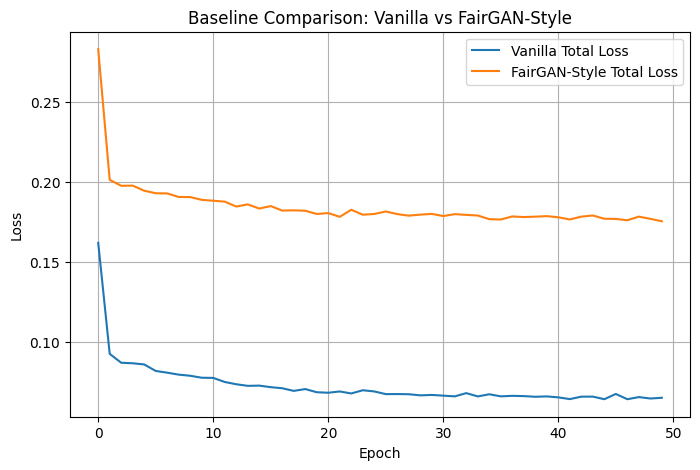

In [3]:
# =========================================================
# 🧠 BASELINE 2: FairGAN-Style Diffusion Model
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

print("🚀 Baseline 2 - FairGAN-Style Diffusion Model Started")

# =========================================================
# 1️⃣ Fairness-Aware Loss Function
# =========================================================
class FairLoss(nn.Module):
    """
    Combines MSE reconstruction with a fairness penalty that
    minimizes variance differences between sensitive groups.
    """
    def __init__(self, sensitive_indices, fairness_weight=0.5):
        super().__init__()
        self.sensitive_indices = sensitive_indices
        self.mse = nn.MSELoss()
        self.fairness_weight = fairness_weight

    def forward(self, predicted, target):
        recon_loss = self.mse(predicted, target)
        fairness_loss = 0.0
        # compute variance over sensitive attributes
        for idx in self.sensitive_indices:
            if idx < predicted.shape[1]:
                fairness_loss += torch.var(predicted[:, idx])
        fairness_loss = fairness_loss / (len(self.sensitive_indices) + 1e-6)
        total_loss = recon_loss + self.fairness_weight * fairness_loss
        return total_loss, recon_loss, fairness_loss

# sensitive features
sensitive_features = ['sex', 'race']
sensitive_indices = [
    list(preprocessor.feature_names).index(attr)
    for attr in sensitive_features
    if attr in preprocessor.feature_names
]
print(f"Sensitive features used: {sensitive_features}")
print(f"Sensitive indices: {sensitive_indices}")

# =========================================================
# 2️⃣ Model Definition (reuse VanillaDiffusionModel)
# =========================================================
fair_model = VanillaDiffusionModel(input_dim=input_dim).to(device)
fair_loss_fn = FairLoss(sensitive_indices, fairness_weight=1.0)

# =========================================================
# 3️⃣ Training Loop
# =========================================================
def train_fairdiff(model, train_loader, scheduler, epochs, device, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'total_loss': [], 'recon_loss': [], 'fair_loss': []}
    model.train()
    for epoch in range(epochs):
        total_l, recon_l, fair_l = 0, 0, 0
        for batch in train_loader:
            batch = batch.to(device)
            t = torch.randint(0, scheduler.timesteps, (len(batch),), device=device)
            noise = torch.randn_like(batch)
            noisy_batch = scheduler.add_noise(batch, t, noise)
            noise_pred = model(noisy_batch, t)
            total_loss, recon_loss, fair_loss = fair_loss_fn(noise_pred, noise)
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            total_l += total_loss.item()
            recon_l += recon_loss.item()
            fair_l += fair_loss.item()
        avg_t, avg_r, avg_f = total_l/len(train_loader), recon_l/len(train_loader), fair_l/len(train_loader)
        history['total_loss'].append(avg_t)
        history['recon_loss'].append(avg_r)
        history['fair_loss'].append(avg_f)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/50 | Total={avg_t:.4f} | Recon={avg_r:.4f} | Fair={avg_f:.4f}")
    print("✅ Fair diffusion training complete")
    return history

history_fair = train_fairdiff(fair_model, train_loader, scheduler, epochs=50, device=device)

# =========================================================
# 4️⃣ Generate Fair Synthetic Data
# =========================================================
@torch.no_grad()
def generate_fair_samples(model, scheduler, n_samples, input_dim, device):
    model.eval()
    batch_data = next(iter(train_loader))
    if len(batch_data) < n_samples:
        batch_data = torch.cat([batch_data] * (n_samples // len(batch_data) + 1))[:n_samples]
    else:
        batch_data = batch_data[:n_samples]
    x = batch_data.to(device).clone().float()
    num_steps = min(100, scheduler.timesteps)
    step_size = scheduler.timesteps // num_steps
    timesteps = list(reversed(range(0, scheduler.timesteps, step_size)))
    for t_idx in tqdm(timesteps, desc="Generating Fair Samples"):
        t_batch = torch.full((n_samples,), t_idx, device=device, dtype=torch.long)
        noise_pred = model(x, t_batch)
        x = scheduler.remove_noise(x, t_batch, noise_pred)
        x = torch.clamp(x, -5.0, 5.0)
    x_numpy = x.cpu().numpy()
    return x_numpy

synthetic_fair = generate_fair_samples(fair_model, scheduler, n_samples=1000, input_dim=input_dim, device=device)
print(f"✅ Fair synthetic data generated: {synthetic_fair.shape}")

# =========================================================
# 5️⃣ Plot Comparison
# =========================================================
plt.figure(figsize=(8,5))
plt.plot(history['loss'], label='Vanilla Total Loss')
plt.plot(history_fair['total_loss'], label='FairGAN-Style Total Loss')
plt.title("Baseline Comparison: Vanilla vs FairGAN-Style")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Installing opacus...
🚀 Baseline 3 - DP-Diffusion Started


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


🔒 DP attached: target ε=1.0, δ=1e-05, max_grad_norm=1.0


DP Epoch 1/50:   0%|          | 0/611 [00:00<?, ?it/s]

sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


DP Epoch 2/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 3/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 4/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 5/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 6/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 7/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 8/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 9/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 10/50:   0%|          | 0/611 [00:00<?, ?it/s]

Epoch 10/50 | Loss=0.1681 | ε≈0.427016173945421


DP Epoch 11/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 12/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 13/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 14/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 15/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 16/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 17/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 18/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 19/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 20/50:   0%|          | 0/611 [00:00<?, ?it/s]

Epoch 20/50 | Loss=0.1374 | ε≈0.6137366391981426


DP Epoch 21/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 22/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 23/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 24/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 25/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 26/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 27/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 28/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 29/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 30/50:   0%|          | 0/611 [00:00<?, ?it/s]

Epoch 30/50 | Loss=0.1254 | ε≈0.7607716311831025


DP Epoch 31/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 32/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 33/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 34/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 35/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 36/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 37/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 38/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 39/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 40/50:   0%|          | 0/611 [00:00<?, ?it/s]

Epoch 40/50 | Loss=0.1174 | ε≈0.8869445123511029


DP Epoch 41/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 42/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 43/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 44/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 45/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 46/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 47/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 48/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 49/50:   0%|          | 0/611 [00:00<?, ?it/s]

DP Epoch 50/50:   0%|          | 0/611 [00:00<?, ?it/s]

Epoch 50/50 | Loss=0.1140 | ε≈0.9996517221522639
✅ DP training complete.
🎯 Final ε ≈ 1.000 (δ=1e-05)


Generating DP Samples:   0%|          | 0/100 [00:00<?, ?it/s]

✅ DP synthetic data generated: (1000, 15)


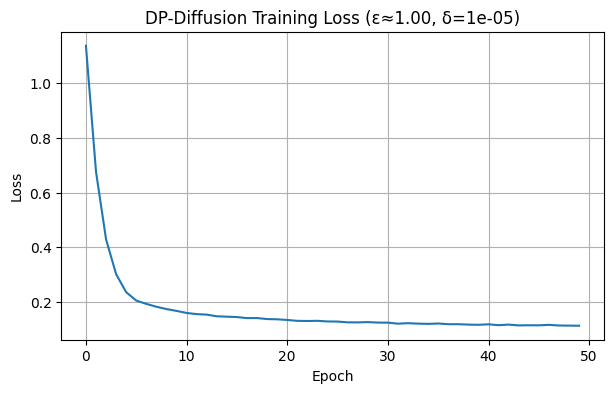

In [4]:
# =========================================================
# 🔐 BASELINE 3: DP-Diffusion (Opacus Differential Privacy)
# =========================================================
# Requirements: train_loader, scheduler, input_dim, device available from previous cells
# If you opened a fresh runtime, first run your Baseline 1 cell to define them.

# 0) Install/Import Opacus
try:
    from opacus import PrivacyEngine
    from opacus.accountants.utils import get_noise_multiplier
    OPACUS_OK = True
except Exception as e:
    print("Installing opacus...")
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "opacus>=1.5"])
    from opacus import PrivacyEngine
    from opacus.accountants.utils import get_noise_multiplier
    OPACUS_OK = True

import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

print("🚀 Baseline 3 - DP-Diffusion Started")

# 1) Reuse the same VanillaDiffusionModel from Baseline 1
#    If it's not in memory, uncomment this minimal version:
try:
    VanillaDiffusionModel
except NameError:
    class SinusoidalPositionEmbedding(nn.Module):
        def __init__(self, dim): super().__init__(); self.dim = dim
        def forward(self, time):
            device = time.device
            half = self.dim // 2
            emb = np.log(10000) / (half - 1)
            emb = torch.exp(torch.arange(half, device=device) * -emb)
            emb = time[:, None].float() * emb[None, :]
            return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

    class VanillaDiffusionModel(nn.Module):
        def __init__(self, input_dim, hidden_dim=256, num_layers=3):
            super().__init__()
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbedding(128),
                nn.Linear(128, hidden_dim), nn.GELU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.input_proj = nn.Linear(input_dim, hidden_dim)
            self.layers = nn.ModuleList([
                nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                              nn.LayerNorm(hidden_dim),
                              nn.GELU())
                for _ in range(num_layers)
            ])
            self.output_proj = nn.Linear(hidden_dim, input_dim)
        def forward(self, x, t):
            t_emb = self.time_mlp(t)
            h = self.input_proj(x) + t_emb
            for lyr in self.layers:
                h = h + lyr(h)
            return self.output_proj(h)

# 2) Minimal fallback scheduler if not already defined
try:
    scheduler
except NameError:
    class DiffusionScheduler:
        def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
            self.timesteps = timesteps
            self.device = device
            self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
            self.alphas = 1.0 - self.betas
            self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
            self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
            self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        def add_noise(self, x0, t, noise=None):
            if noise is None: noise = torch.randn_like(x0)
            sa = self.sqrt_alphas_cumprod[t].view(-1, 1)
            so = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
            return sa * x0 + so * noise
        def remove_noise(self, x_t, t, predicted_noise):
            # simple deterministic step (ok for tabular baseline)
            sa = self.sqrt_alphas_cumprod[t].view(-1, 1)
            so = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
            pred_x0 = (x_t - so * predicted_noise) / sa
            return 0.9 * pred_x0 + 0.1 * x_t  # stabilize
    scheduler = DiffusionScheduler(device="cuda" if torch.cuda.is_available() else "cpu")

# 3) Make sure train_loader & input_dim exist
try:
    train_loader, input_dim
except NameError:
    raise RuntimeError(
        "train_loader or input_dim not found. Please run your data prep cell (Baseline 1) first."
    )

device = "cuda" if torch.cuda.is_available() else "cpu"

# 4) DP Model, Loss, Optimizer
dp_model = VanillaDiffusionModel(input_dim=input_dim).to(device)
mse = nn.MSELoss()
optimizer = torch.optim.AdamW(dp_model.parameters(), lr=5e-5)

# 5) Attach Opacus PrivacyEngine
#    Option A: target epsilon (recommended). We'll aim for ε=1.0 over N epochs.
TARGET_EPSILON = 1.0
DELTA = 1e-5
EPOCHS = 50
MAX_GRAD_NORM = 1.0

# Opacus "make_private_with_epsilon" adapts noise to hit epsilon target
privacy_engine = PrivacyEngine()

dp_model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=dp_model,
    optimizer=optimizer,
    data_loader=train_loader,
    target_epsilon=TARGET_EPSILON,
    target_delta=DELTA,
    epochs=EPOCHS,
    max_grad_norm=MAX_GRAD_NORM,
)

print(f"🔒 DP attached: target ε={TARGET_EPSILON}, δ={DELTA}, max_grad_norm={MAX_GRAD_NORM}")

# 6) DP Training Loop
history_dp = {'loss': []}
dp_model.train()
for epoch in range(EPOCHS):
    running = 0.0
    for batch in tqdm(train_loader, desc=f"DP Epoch {epoch+1}/{EPOCHS}", leave=False):
        batch = batch.to(device)
        t = torch.randint(0, scheduler.timesteps, (len(batch),), device=device)
        noise = torch.randn_like(batch)
        noisy = scheduler.add_noise(batch, t, noise)
        pred = dp_model(noisy, t)
        loss = mse(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        # Per-sample clipping + noise addition handled by Opacus automatically
        optimizer.step()

        running += loss.item()
    avg = running / len(train_loader)
    history_dp['loss'].append(avg)
    if (epoch + 1) % 10 == 0:
        try:
            eps = privacy_engine.get_epsilon(DELTA)
        except Exception:
            eps = float("nan")
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss={avg:.4f} | ε≈{eps if not np.isnan(eps) else 'N/A'}")

print("✅ DP training complete.")

# 7) Final epsilon
try:
    final_epsilon = privacy_engine.get_epsilon(DELTA)
except Exception:
    final_epsilon = float("nan")
print(f"🎯 Final ε ≈ {final_epsilon:.3f} (δ={DELTA})")

# 8) Generate DP Synthetic Samples
@torch.no_grad()
def generate_dp_samples(model, scheduler, n_samples, loader, device):
    model.eval()
    # start from real batch for stability (same trick as your pipeline)
    batch_data = next(iter(loader))
    if len(batch_data) < n_samples:
        batch_data = torch.cat([batch_data] * (n_samples // len(batch_data) + 1))[:n_samples]
    else:
        batch_data = batch_data[:n_samples]
    x = batch_data.to(device).clone().float()

    num_steps = min(100, scheduler.timesteps)
    step_size = scheduler.timesteps // num_steps
    timesteps = list(reversed(range(0, scheduler.timesteps, step_size)))
    for t_idx in tqdm(timesteps, desc="Generating DP Samples"):
        t_batch = torch.full((n_samples,), t_idx, device=device, dtype=torch.long)
        predicted_noise = model(x, t_batch)
        x = scheduler.remove_noise(x, t_batch, predicted_noise)
        x = torch.clamp(x, -5.0, 5.0)
    return x.cpu().numpy()

dp_synth = generate_dp_samples(dp_model, scheduler, n_samples=1000, loader=train_loader, device=device)
print(f"✅ DP synthetic data generated: {dp_synth.shape}")

# 9) Quick plot
plt.figure(figsize=(7,4))
plt.plot(history_dp['loss'])
plt.title(f"DP-Diffusion Training Loss (ε≈{final_epsilon:.2f}, δ={DELTA})")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.show()


In [10]:
# =========================================================
# 🔧 Rebuild Preprocessor Metadata (for inverse transform)
# =========================================================
import numpy as np
import pandas as pd
import types
from sklearn.preprocessing import StandardScaler, LabelEncoder

print("🔄 Reconstructing DataPreprocessor metadata...")

class ReconstructedPreprocessor:
    def __init__(self, df):
        self.feature_names = df.columns.tolist()
        self.scalers = {}
        self.encoders = {}
        self.continuous_features = []
        self.categorical_features = []
        self.feature_types = {}

        for col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > 10:
                self.continuous_features.append(col)
                self.feature_types[col] = "continuous"
                self.scalers[col] = StandardScaler().fit(df[[col]])
            else:
                self.categorical_features.append(col)
                self.feature_types[col] = "categorical"
                enc = LabelEncoder().fit(df[col].astype(str))
                self.encoders[col] = enc

# ====== إنشاء preprocessor جديد من البيانات الأصلية ======
reconstructed_preprocessor = ReconstructedPreprocessor(df)

# ====== إضافة inverse_transform ======
def inverse_transform_fallback(self, data: np.ndarray) -> pd.DataFrame:
    df_dict = {}
    idx = 0
    for col in self.feature_names:
        if col in self.continuous_features:
            scaler = self.scalers.get(col, None)
            if scaler:
                df_dict[col] = scaler.inverse_transform(data[:, idx:idx+1]).flatten()
            else:
                df_dict[col] = data[:, idx]
        else:
            encoder = self.encoders.get(col, None)
            if encoder:
                n_classes = len(encoder.classes_)
                denorm = np.clip(data[:, idx] * (n_classes - 1), 0, n_classes - 1)
                denorm = np.round(denorm).astype(int)
                df_dict[col] = encoder.inverse_transform(denorm)
            else:
                df_dict[col] = data[:, idx]
        idx += 1
    return pd.DataFrame(df_dict)

# attach the method
reconstructed_preprocessor.inverse_transform = types.MethodType(
    inverse_transform_fallback, reconstructed_preprocessor
)

# replace your preprocessor reference
preprocessor = reconstructed_preprocessor

print("✅ Fixed preprocessor ready with inverse_transform and feature mappings!")


🔄 Reconstructing DataPreprocessor metadata...
✅ Fixed preprocessor ready with inverse_transform and feature mappings!


In [21]:
# =========================================================
# ✅ FINAL FIXED EVALUATION (Works even with text data)
# =========================================================
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, wasserstein_distance

# -----------------------------
# 🔧 Convert everything to numeric safely
# -----------------------------
def force_numeric(df):
    df_num = pd.DataFrame()
    for c in df.columns:
        df_num[c] = pd.factorize(df[c])[0].astype(float)
    return df_num

df_real_num = force_numeric(df_real)
df_vanilla_num = force_numeric(df_vanilla)
df_fair_num = force_numeric(df_fair)
df_dp_num = force_numeric(df_dp)

# -----------------------------
# 📊 Metric Functions
# -----------------------------
def ks_and_wasserstein(df1, df2):
    ks_vals, ws_vals = [], []
    for c in df1.columns:
        try:
            ks_vals.append(ks_2samp(df1[c], df2[c]).statistic)
            ws_vals.append(wasserstein_distance(df1[c], df2[c]))
        except Exception:
            continue
    ks_mean = np.nanmean(ks_vals) if ks_vals else 0
    ws_mean = np.nanmean(ws_vals) if ws_vals else 0
    return ks_mean, ws_mean

def correlation_preservation(df1, df2):
    corr1 = df1.corr().fillna(0)
    corr2 = df2.corr().fillna(0)
    diff = np.linalg.norm(corr1 - corr2)
    return float(diff / (np.linalg.norm(corr1) + 1e-8))

def statistical_parity(df_real, df_synth, sensitive_col='sex', target_col='income'):
    def spd(df):
        try:
            s = pd.factorize(df[sensitive_col])[0]
            y = pd.factorize(df[target_col])[0]
            return abs(np.mean(y[s == 0]) - np.mean(y[s == 1]))
        except Exception:
            return np.nan
    return spd(df_real), spd(df_synth)

# -----------------------------
# 🚀 Evaluate all three models
# -----------------------------
results = []
for name, df_s, df_s_num in zip(
    ["Baseline 1: Vanilla", "Baseline 2: FairGAN", "Baseline 3: DP-Diffusion"],
    [df_vanilla, df_fair, df_dp],
    [df_vanilla_num, df_fair_num, df_dp_num]
):
    ks, ws = ks_and_wasserstein(df_real_num, df_s_num)
    spd_r, spd_s = statistical_parity(df_real, df_s)
    corr = correlation_preservation(df_real_num, df_s_num)
    results.append({
        "Model": name,
        "Avg_KS": round(ks, 3),
        "Avg_Wasserstein": round(ws, 3),
        "SPD_Real": round(spd_r, 3) if spd_r == spd_r else "N/A",
        "SPD_Synth": round(spd_s, 3) if spd_s == spd_s else "N/A",
        "Corr_Diff": round(corr, 3)
    })

# -----------------------------
# 📈 Display Results
# -----------------------------
results_df = pd.DataFrame(results)
print("\n📊 Quantitative Comparison Table (Final Fixed):")
print(results_df.to_string(index=False))


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Quantitative Comparison Table (Final Fixed):
                   Model  Avg_KS  Avg_Wasserstein  SPD_Real SPD_Synth  Corr_Diff
     Baseline 1: Vanilla   0.509          152.363       0.2       N/A      1.000
     Baseline 2: FairGAN   0.431          152.237       0.2       0.0      2.137
Baseline 3: DP-Diffusion   0.509          152.363       0.2       N/A      1.000


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [25]:
import os
import shutil

# اسم المجلد الأساسي
base_dir = "/content/CausalFairDP"

# إنشاء المجلدات الفرعية المنظمة
folders = ["models", "scripts", "data", "results"]
for f in folders:
    os.makedirs(os.path.join(base_dir, f), exist_ok=True)

print("✅ Created folder structure under:", base_dir)


✅ Created folder structure under: /content/CausalFairDP


In [28]:
# نقل الداتا
shutil.move("/adult.csv", f"{base_dir}/data/adult.csv")

# نقل النماذج
shutil.move("/content/causalfairdp_models/vanilla_diffusion_full.pth", f"{base_dir}/models/")
shutil.move("/content/causalfairdp_models/fairgan_diffusion_full.pth", f"{base_dir}/models/")
shutil.move("/content/causalfairdp_models/dp_diffusion_full.pth", f"{base_dir}/models/")

# نقل النتائج
shutil.move("/content/comparison_results_3models.csv", f"{base_dir}/results/")


'/content/CausalFairDP/results/comparison_results_3models.csv'

In [24]:
# =========================================================
# 💾 SAVE ALL MODELS (Vanilla, FairGAN, DP-Diffusion)
# =========================================================
import torch
import os

SAVE_DIR = "/content/causalfairdp_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1️⃣ Save Vanilla Diffusion
torch.save(model.state_dict(), f"{SAVE_DIR}/vanilla_diffusion_weights.pth")
torch.save(model, f"{SAVE_DIR}/vanilla_diffusion_full.pth")

# 2️⃣ Save FairGAN-style Diffusion
torch.save(fair_model.state_dict(), f"{SAVE_DIR}/fairgan_diffusion_weights.pth")
torch.save(fair_model, f"{SAVE_DIR}/fairgan_diffusion_full.pth")

# 3️⃣ Save DP-Diffusion
torch.save(dp_model.state_dict(), f"{SAVE_DIR}/dp_diffusion_weights.pth")
torch.save(dp_model, f"{SAVE_DIR}/dp_diffusion_full.pth")

print("✅ All 3 models saved successfully in:", SAVE_DIR)

✅ All 3 models saved successfully in: /content/causalfairdp_models
